# 📈 Nifty Trading Strategy (Intraday & Positional)

This notebook demonstrates two trading strategies using historical NIFTY data:
- **Intraday Strategy** using RSI and EMA
- **Positional Strategy** using SMA Crossover

Data is fetched using `yfinance` from 2018 to 2025.

In [36]:
# 📦 Install required libraries (if needed)
# !pip install yfinance ta pandas matplotlib plotly
!pip install ta

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29421 sha256=343dccc18708d305a279c1c731fe544a5c778af2b0958ee2750cce29220d1cc3
  Stored in directory: c:\users\user\appdata\local\pip\cache\wheels\5c\a1\5f\c6b85a7d9452057be4ce68a8e45d77ba34234a6d46581777c6
Successfully built ta


In [82]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import ta
import warnings
warnings.filterwarnings('ignore')

## 📥 Load NIFTY Data

In [72]:
# Load NIFTY Daily Data (2018-2025)
nifty_daily = yf.download("^NSEI", start="2018-01-01", end="2025-01-01", interval='1d')
nifty_daily.dropna(inplace=True)
nifty_daily.head()
nifty_daily.tail()

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,^NSEI,^NSEI,^NSEI,^NSEI,^NSEI
Date,,,,,
2024-12-24,23727.650391,23867.650391,23685.150391,23769.099609,177700
2024-12-26,23750.199219,23854.500000,23653.599609,23775.800781,177700
2024-12-27,23813.400391,23938.849609,23800.599609,23801.400391,176800
2024-12-30,23644.900391,23915.349609,23599.300781,23796.900391,364900
2024-12-31,23644.800781,23689.849609,23460.449219,23560.599609,193600


## 📊 Positional Strategy: 50/200 SMA Crossover

In [44]:
nifty_daily['SMA50'] = nifty_daily['Close'].rolling(window=50).mean()
nifty_daily['SMA200'] = nifty_daily['Close'].rolling(window=200).mean()
nifty_daily['Signal'] = (nifty_daily['SMA50'] > nifty_daily['SMA200']).astype(int)
nifty_daily['Position'] = nifty_daily['Signal'].diff()
nifty_daily[['Close', 'SMA50', 'SMA200', 'Signal', 'Position']].tail()

Price,Close,SMA50,SMA200,Signal,Position
Ticker,^NSEI,,,,
Date,,,,,
2024-12-24,23727.650391,24276.136055,23847.006729,1,0.0
2024-12-26,23750.199219,24248.581055,23854.063975,1,0.0
2024-12-27,23813.400391,24223.702070,23861.102979,1,0.0
2024-12-30,23644.900391,24197.174062,23867.545977,1,0.0
2024-12-31,23644.800781,24175.073086,23873.399727,1,0.0


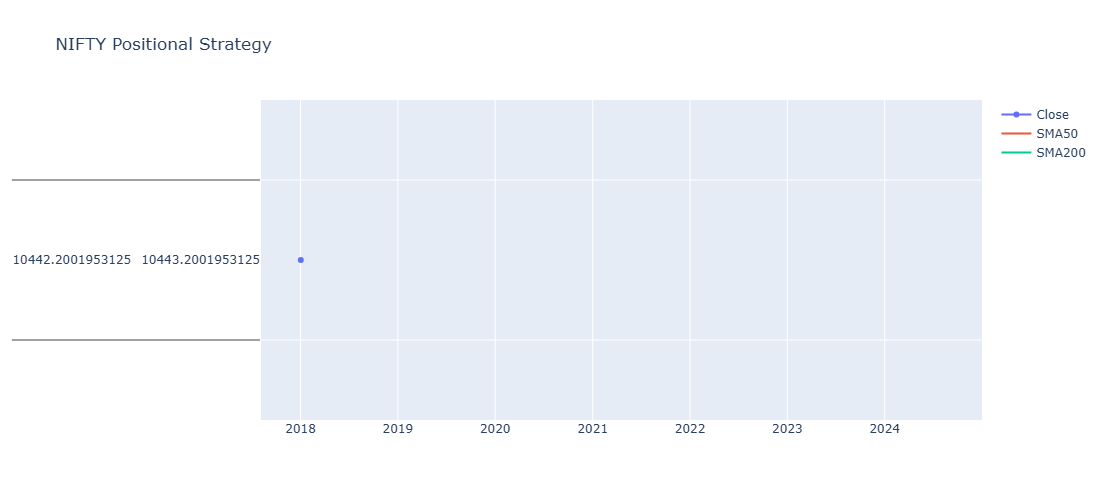

In [46]:
# Plot with Plotly
fig = go.Figure()
fig.add_trace(go.Scatter(x=nifty_daily.index, y=nifty_daily['Close'], name='Close'))
fig.add_trace(go.Scatter(x=nifty_daily.index, y=nifty_daily['SMA50'], name='SMA50'))
fig.add_trace(go.Scatter(x=nifty_daily.index, y=nifty_daily['SMA200'], name='SMA200'))
fig.update_layout(title='NIFTY Positional Strategy', height=500)
fig.show()

## ⏱ Intraday Strategy: EMA + RSI

[*********************100%***********************]  1 of 1 completed


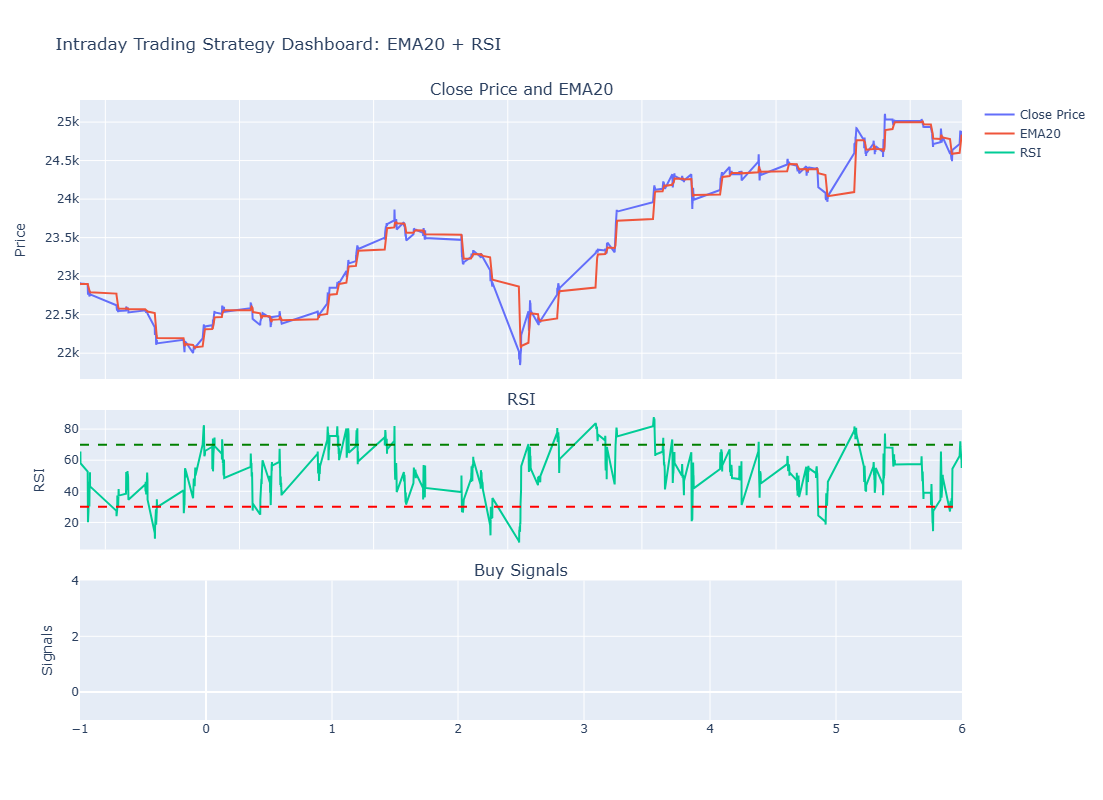

In [74]:
import yfinance as yf
import pandas as pd
from ta.trend import EMAIndicator
from ta.momentum import RSIIndicator
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Step 1: Download intraday data
nifty_intra = yf.download("^NSEI", period="60d", interval="15m")
nifty_intra.dropna(inplace=True)

# Step 2: Flatten MultiIndex columns to single level
nifty_intra.columns = ['_'.join(col).strip() if col[1] else col[0] for col in nifty_intra.columns.values]

# Step 3: Calculate indicators
close_series = nifty_intra['Close_^NSEI']

nifty_intra['EMA20'] = EMAIndicator(close=close_series, window=20).ema_indicator()
nifty_intra['RSI'] = RSIIndicator(close=close_series, window=14).rsi()

nifty_intra.dropna(subset=['EMA20', 'RSI'], inplace=True)

# Step 4: Create Buy Signal: RSI < 30 AND Close > EMA20
nifty_intra['Signal'] = ((nifty_intra['RSI'] < 30) & (nifty_intra['Close_^NSEI'] > nifty_intra['EMA20'])).astype(int)

# Step 5: Plotting with Plotly

fig = make_subplots(
    rows=3, cols=1,
    shared_xaxes=True,
    vertical_spacing=0.05,
    subplot_titles=("Close Price and EMA20", "RSI", "Buy Signals"),
    row_heights=[0.5, 0.25, 0.25]
)

# Close Price + EMA20
fig.add_trace(go.Scatter(
    x=nifty_intra.index,
    y=nifty_intra['Close_^NSEI'],
    mode='lines',
    name='Close Price'
), row=1, col=1)

fig.add_trace(go.Scatter(
    x=nifty_intra.index,
    y=nifty_intra['EMA20'],
    mode='lines',
    name='EMA20'
), row=1, col=1)

# RSI line and threshold lines
fig.add_trace(go.Scatter(
    x=nifty_intra.index,
    y=nifty_intra['RSI'],
    mode='lines',
    name='RSI'
), row=2, col=1)

fig.add_hline(y=30, line_dash="dash", line_color="red", row=2, col=1)
fig.add_hline(y=70, line_dash="dash", line_color="green", row=2, col=1)

# Buy signals (scatter plot with markers where Signal == 1)
buy_signals = nifty_intra[nifty_intra['Signal'] == 1]
fig.add_trace(go.Scatter(
    x=buy_signals.index,
    y=buy_signals['Close_^NSEI'],
    mode='markers',
    marker=dict(color='green', size=10, symbol='triangle-up'),
    name='Buy Signal'
), row=3, col=1)

# Update layout
fig.update_layout(
    height=800,
    title_text="Intraday Trading Strategy Dashboard: EMA20 + RSI",
    showlegend=True
)

fig.update_yaxes(title_text="Price", row=1, col=1)
fig.update_yaxes(title_text="RSI", row=2, col=1)
fig.update_yaxes(title_text="Signals", row=3, col=1)

fig.show()


In [78]:
pip install kiteconnect

In [80]:
#I don't have Zerodha Acc so can't use API here.

from kiteconnect import KiteConnect
import datetime

api_key = "your_api_key_here"
api_secret = "your_api_secret_here"

kite = KiteConnect(api_key=api_key)

# Generate login URL and visit it to get request_token (once)
print(kite.login_url())

# After login, get request_token from redirected URL
request_token = "obtained_request_token_here"

# Get access token (valid for the session)
data = kite.generate_session(request_token, api_secret=api_secret)
kite.set_access_token(data["access_token"])

# Fetch profile info (to confirm login)
profile = kite.profile()
print(profile)

# Place a market order to buy 1 lot of Nifty 50 futures (example)
try:
    order_id = kite.place_order(
        variety=kite.VARIETY_REGULAR,
        exchange=kite.EXCHANGE_NFO,
        tradingsymbol="NIFTY21JUNFUT",  # example futures symbol, adjust as per expiry
        transaction_type=kite.TRANSACTION_TYPE_BUY,
        quantity=75,  # Nifty lot size = 75
        product=kite.PRODUCT_MIS,  # Intraday product
        order_type=kite.ORDER_TYPE_MARKET
    )
    print(f"Order placed successfully, ID: {order_id}")
except Exception as e:
    print("Order placement failed:", e)


https://kite.zerodha.com/connect/login?api_key=your_api_key_here&v=3


TokenException: Token is invalid or has expired.